# CP32 — Team C — Cars24 Web Scraping Mini Project

### Project Objective
Develop hands-on skills in web scraping, data cleaning, and structured data presentation by extracting car details from Cars24. The focus is on listings in India, with location handling as specified below.

In [1]:
# Step 0: Dependency Installation (Optional - for new environments)
# Uncomment and run the following lines if you need to install dependencies in a new kernel
# !pip install requests beautifulsoup4 pandas

# Note: For production environments, create a requirements.txt file with:
# requests>=2.25.0
# beautifulsoup4>=4.9.0
# pandas>=1.3.0

# Then install with: pip install -r requirements.txt

print("Dependency installation cell ready (commented for safety)")

Dependency installation cell ready (commented for safety)


In [2]:
# Step 1: Importing Required Libraries and Checking Versions

import requests                      # For sending HTTP requests
from bs4 import BeautifulSoup         # For parsing HTML content
import pandas as pd                   # For data manipulation and analysis
import os                             # For creating project structure
import sys                            # For system information
import urllib.robotparser             # For robots.txt checking

# Print package versions for reproducibility
print("=== Package Versions ===")
print(f"requests: {requests.__version__}")
try:
    import bs4
    print(f"beautifulsoup4: {bs4.__version__}")
except AttributeError:
    print("beautifulsoup4: Version not available")
print(f"pandas: {pd.__version__}")
print(f"Python: {sys.version}")
print("\nLibraries imported successfully!")

=== Package Versions ===
requests: 2.32.3
beautifulsoup4: 4.12.3
pandas: 2.2.3
Python: 3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]

Libraries imported successfully!


In [3]:
# Step 2: Robots.txt Compliance Check
# Demonstrating awareness of scraping rules and ethical guidelines

def check_robots_txt(base_url):
    """Check robots.txt for scraping permissions"""
    try:
        rp = urllib.robotparser.RobotFileParser()
        rp.set_url(f"{base_url}/robots.txt")
        rp.read()
        
        print("=== Robots.txt Analysis ===")
        print(f"Checking robots.txt for: {base_url}")
        
        # Check if we can access the main page
        can_fetch = rp.can_fetch("*", "/")
        print(f"Can fetch main page: {can_fetch}")
        
        # Check specific paths we might need
        search_paths = ["/buy-used-hyundai-cars-mumbai/", "/buy-used-cars/"]
        for path in search_paths:
            can_access = rp.can_fetch("*", path)
            print(f"Can access {path}: {can_access}")
        
        # Get crawl delay if specified
        crawl_delay = rp.crawl_delay("*")
        if crawl_delay:
            print(f"Recommended crawl delay: {crawl_delay} seconds")
        else:
            print("No specific crawl delay specified")
            
        return rp
        
    except Exception as e:
        print(f"Error checking robots.txt: {e}")
        return None

# Check robots.txt for Cars24
base_url = "https://www.cars24.com"
robots_parser = check_robots_txt(base_url)


=== Robots.txt Analysis ===
Checking robots.txt for: https://www.cars24.com
Can fetch main page: False
Can access /buy-used-hyundai-cars-mumbai/: False
Can access /buy-used-cars/: False
No specific crawl delay specified


In [4]:
# Step 3: Basic HTTP Connectivity Test
# Simple connectivity check without detailed exception handling

# Create a session with proper headers
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
})

# Make request
response = session.get("https://www.cars24.com/buy-used-hyundai-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=Homepage_Filters", timeout=10)

print("=== Website Connectivity Test ===")
print(f"✓ HTTP Status: {response.status_code}")
print(f"✓ Content Length: {len(response.content)} bytes")
print(f"✓ Content Type: {response.headers.get('content-type', 'Unknown')}")

# Basic page validation
soup = BeautifulSoup(response.content, 'html.parser')
title = soup.find('title')
if title:
    print(f"✓ Page Title: {title.get_text().strip()}")

print("✓ Successfully connected to Cars24 website")


=== Website Connectivity Test ===
✓ HTTP Status: 200
✓ Content Length: 1195715 bytes
✓ Content Type: text/html; charset=utf-8
✓ Page Title: 435 Hyundai Used Cars in Mumbai | Second Hand Hyundai Cars in Mumbai starting from ₹0.89 lakh - CARS24
✓ Successfully connected to Cars24 website


In [5]:
# Step 4: Project Structure Setup

project_dir = "cars24_hyundai_mumbai"              # name of the project folder
if not os.path.exists(project_dir):                # Check if the directory already exists
    os.makedirs(project_dir)                       # If not, create the directory
    print(f"Project directory '{project_dir}' created successfully.")
else:
    print(f"Project directory '{project_dir}' already exists.")                # Printing a message if it already exists

Project directory 'cars24_hyundai_mumbai' already exists.


In [6]:
# Step 5: Advanced HTTP Handling with Retries, Logging, and Robust Error Handling

import logging
import time
from typing import Tuple, Optional, Dict, Any
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from requests.exceptions import Timeout, ConnectionError, HTTPError, RequestException

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('cars24_scraper.log', mode='a')
    ]
)
logger = logging.getLogger(__name__)

# Declaring the target website URL
TARGET_URL = "https://www.cars24.com/buy-used-hyundai-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=Homepage_Filters"

def create_robust_session() -> requests.Session:
    """
    Create a session with retry strategy and proper adapters.
    
    Returns:
        requests.Session: Configured session with retry behavior
    """
    session = requests.Session()
    
    # Configure retry strategy with exponential backoff
    retry_strategy = Retry(
        total=3,  # Total number of retries
        backoff_factor=1,  # Exponential backoff factor
        status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
        allowed_methods=["HEAD", "GET", "OPTIONS"]  # Only retry safe methods
    )
    
    # Mount adapter with retry strategy
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    # Set headers
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
    })
    
    return session

def validate_response_content(response: requests.Response) -> Tuple[bool, str]:
    """
    Validate response content for basic checks.
    
    Args:
        response: The HTTP response object
        
    Returns:
        Tuple[bool, str]: (is_valid, reason)
    """
    # Check content type
    content_type = response.headers.get('content-type', '').lower()
    if 'text/html' not in content_type:
        return False, f"Invalid content type: {content_type}"
    
    # Check minimum content length
    if len(response.content) < 1000:
        return False, f"Content too short: {len(response.content)} bytes"
    
    # Check for common error indicators
    content_lower = response.text.lower()
    error_indicators = ['captcha', 'access denied', 'blocked', 'forbidden']
    for indicator in error_indicators:
        if indicator in content_lower:
            return False, f"Error indicator found: {indicator}"
    
    return True, "Content validation passed"

def get_robust_response(url: str, session: Optional[requests.Session] = None, 
                       timeout_seconds: int = 15) -> Tuple[Optional[requests.Response], Optional[Dict[str, Any]]]:
    """
    Advanced robust HTTP request function with comprehensive error handling.
    
    Args:
        url (str): The target website URL
        session (requests.Session, optional): Pre-configured session. If None, creates new one
        timeout_seconds (int): Request timeout in seconds
        
    Returns:
        Tuple[Optional[requests.Response], Optional[Dict[str, Any]]]: 
            (response, None) on success, (None, error_info) on failure
    """
    
    if session is None:
        session = create_robust_session()
    
    error_info = {
        'url': url,
        'timestamp': time.time(),
        'error_type': None,
        'error_message': None,
        'status_code': None,
        'retry_after': None
    }
    
    try:
        logger.info(f"Attempting to fetch: {url}")
        
        # Make the request
        response = session.get(url, timeout=timeout_seconds)
        
        # Handle rate limiting (429 Too Many Requests)
        if response.status_code == 429:
            retry_after = response.headers.get('Retry-After')
            if retry_after:
                wait_time = int(retry_after)
                logger.warning(f"Rate limited. Waiting {wait_time} seconds as per Retry-After header")
                time.sleep(wait_time)
                # Retry once after waiting
                response = session.get(url, timeout=timeout_seconds)
            else:
                logger.warning("Rate limited but no Retry-After header found")
        
        # Differentiate 4xx vs 5xx errors
        if response.status_code >= 400:
            if 400 <= response.status_code < 500:
                # Client error (4xx)
                error_info.update({
                    'error_type': 'ClientError',
                    'error_message': f'Client error: {response.status_code} {response.reason}',
                    'status_code': response.status_code
                })
                logger.error(f"Client error {response.status_code}: {response.reason}")
                return None, error_info
            else:
                # Server error (5xx)
                error_info.update({
                    'error_type': 'ServerError', 
                    'error_message': f'Server error: {response.status_code} {response.reason}',
                    'status_code': response.status_code
                })
                logger.error(f"Server error {response.status_code}: {response.reason}")
                return None, error_info
        
        # Validate response content
        is_valid, validation_reason = validate_response_content(response)
        if not is_valid:
            error_info.update({
                'error_type': 'ContentValidationError',
                'error_message': f'Content validation failed: {validation_reason}',
                'status_code': response.status_code
            })
            logger.error(f"Content validation failed: {validation_reason}")
            return None, error_info
        
        logger.info(f"Success! Status: {response.status_code}, Content: {len(response.content)} bytes")
        return response, None
        
    except Timeout:
        error_info.update({
            'error_type': 'TimeoutError',
            'error_message': f'Request timed out after {timeout_seconds}s'
        })
        logger.error(f"Timeout after {timeout_seconds}s for {url}")
        return None, error_info
        
    except ConnectionError as e:
        error_info.update({
            'error_type': 'ConnectionError',
            'error_message': f'Connection failed: {str(e)}'
        })
        logger.error(f"Connection error for {url}: {e}")
        return None, error_info
        
    except HTTPError as e:
        status_code = e.response.status_code if e.response else None
        error_info.update({
            'error_type': 'HTTPError',
            'error_message': f'HTTP error: {str(e)}',
            'status_code': status_code
        })
        logger.error(f"HTTP error for {url}: {e}")
        return None, error_info
        
    except RequestException as e:
        error_info.update({
            'error_type': 'RequestException',
            'error_message': f'Request exception: {str(e)}'
        })
        logger.error(f"Request exception for {url}: {e}")
        return None, error_info
        
    except Exception as e:
        error_info.update({
            'error_type': 'UnexpectedError',
            'error_message': f'Unexpected error: {str(e)}'
        })
        logger.critical(f"Unexpected error for {url}: {e}")
        return None, error_info


In [7]:
# Step 6: Testing the Advanced HTTP Function

print("=== Advanced HTTP Function Testing ===")

# Create a robust session
robust_session = create_robust_session()

# Test Case 1: Successful Connection (Expected)
print("\n[Test 1: Successful URL]")
response, error = get_robust_response(TARGET_URL, robust_session)
if response:
    print(f"✓ Test 1 Result: Success! Status: {response.status_code}, Content: {len(response.content)} bytes")
    # Parse title for verification
    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.find('title')
    if title:
        print(f"✓ Page Title: {title.get_text().strip()}")
else:
    print(f"✗ Test 1 Failed: {error['error_type']} - {error['error_message']}")

# Test Case 2: 404 Not Found (Expected to fail gracefully)
print("\n[Test 2: Invalid/404 URL]")
response_404, error_404 = get_robust_response("https://www.cars24.com/this-path-does-not-exist-12345/", robust_session)
if not response_404:
    print(f"✓ Test 2 Result: Correctly handled 404 error - {error_404['error_type']}: {error_404['error_message']}")
else:
    print("✗ Test 2 Unexpected: Should have failed but didn't")

# Test Case 3: Test retry behavior with a URL that might cause transient errors
print("\n[Test 3: Testing Retry Behavior]")
# Using a URL that might trigger rate limiting or server errors
test_url = "https://httpbin.org/status/500"  # This will return 500 error
response_500, error_500 = get_robust_response(test_url, robust_session)
if not response_500:
    print(f"✓ Test 3 Result: Correctly handled server error - {error_500['error_type']}: {error_500['error_message']}")
else:
    print("✗ Test 3 Unexpected: Should have failed but didn't")

print("\n=== Testing Complete ===")
print("Check 'cars24_scraper.log' file for detailed logs with timestamps.")


2025-10-19 12:32:57,222 - INFO - Attempting to fetch: https://www.cars24.com/buy-used-hyundai-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=Homepage_Filters


=== Advanced HTTP Function Testing ===

[Test 1: Successful URL]


2025-10-19 12:32:57,641 - INFO - Success! Status: 200, Content: 1196324 bytes
2025-10-19 12:32:57,699 - INFO - Attempting to fetch: https://www.cars24.com/this-path-does-not-exist-12345/


✓ Test 1 Result: Success! Status: 200, Content: 1196324 bytes
✓ Page Title: 435 Hyundai Used Cars in Mumbai | Second Hand Hyundai Cars in Mumbai starting from ₹0.89 lakh - CARS24

[Test 2: Invalid/404 URL]


2025-10-19 12:32:57,959 - ERROR - Client error 404: Not Found
2025-10-19 12:32:57,961 - INFO - Attempting to fetch: https://httpbin.org/status/500


✓ Test 2 Result: Correctly handled 404 error - ClientError: Client error: 404 Not Found

[Test 3: Testing Retry Behavior]


2025-10-19 12:33:15,354 - ERROR - Request exception for https://httpbin.org/status/500: HTTPSConnectionPool(host='httpbin.org', port=443): Max retries exceeded with url: /status/500 (Caused by ResponseError('too many 500 error responses'))


✓ Test 3 Result: Correctly handled server error - RequestException: Request exception: HTTPSConnectionPool(host='httpbin.org', port=443): Max retries exceeded with url: /status/500 (Caused by ResponseError('too many 500 error responses'))

=== Testing Complete ===
Check 'cars24_scraper.log' file for detailed logs with timestamps.


In [8]:
# Step 7: Unit Tests with Mocked Responses

import unittest
from unittest.mock import Mock, patch
import requests

class TestRobustHTTPFunction(unittest.TestCase):
    """Unit tests for the robust HTTP function with mocked responses"""
    
    def setUp(self):
        """Set up test fixtures"""
        self.test_url = "https://example.com"
        self.session = create_robust_session()
    
    def test_successful_response(self):
        """Test successful HTTP response"""
        # Mock successful response with sufficient content size
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.content = b"<html><title>Test Page</title></html>" + b"x" * 1000
        mock_response.headers = {'content-type': 'text/html; charset=utf-8'}
        mock_response.text = "<html><title>Test Page</title></html>" + "x" * 1000
        
        with patch.object(self.session, 'get', return_value=mock_response):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNotNone(response)
            self.assertIsNone(error)
            self.assertEqual(response.status_code, 200)
    
    def test_404_client_error(self):
        """Test 404 client error handling"""
        # Mock 404 response
        mock_response = Mock()
        mock_response.status_code = 404
        mock_response.reason = "Not Found"
        mock_response.content = b"<html>Not Found</html>"
        mock_response.headers = {'content-type': 'text/html'}
        mock_response.text = "<html>Not Found</html>"
        
        with patch.object(self.session, 'get', return_value=mock_response):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNone(response)
            self.assertIsNotNone(error)
            self.assertEqual(error['error_type'], 'ClientError')
            self.assertEqual(error['status_code'], 404)
    
    def test_500_server_error(self):
        """Test 500 server error handling"""
        # Mock 500 response
        mock_response = Mock()
        mock_response.status_code = 500
        mock_response.reason = "Internal Server Error"
        mock_response.content = b"<html>Server Error</html>"
        mock_response.headers = {'content-type': 'text/html'}
        mock_response.text = "<html>Server Error</html>"
        
        with patch.object(self.session, 'get', return_value=mock_response):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNone(response)
            self.assertIsNotNone(error)
            self.assertEqual(error['error_type'], 'ServerError')
            self.assertEqual(error['status_code'], 500)
    
    def test_timeout_error(self):
        """Test timeout error handling"""
        with patch.object(self.session, 'get', side_effect=requests.exceptions.Timeout()):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNone(response)
            self.assertIsNotNone(error)
            self.assertEqual(error['error_type'], 'TimeoutError')
    
    def test_connection_error(self):
        """Test connection error handling"""
        with patch.object(self.session, 'get', side_effect=requests.exceptions.ConnectionError()):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNone(response)
            self.assertIsNotNone(error)
            self.assertEqual(error['error_type'], 'ConnectionError')
    
    def test_content_validation_failure(self):
        """Test content validation failure"""
        # Mock response with invalid content type
        mock_response = Mock()
        mock_response.status_code = 200
        mock_response.content = b"Not HTML"
        mock_response.headers = {'content-type': 'application/json'}
        mock_response.text = "Not HTML"
        
        with patch.object(self.session, 'get', return_value=mock_response):
            response, error = get_robust_response(self.test_url, self.session)
            
            self.assertIsNone(response)
            self.assertIsNotNone(error)
            self.assertEqual(error['error_type'], 'ContentValidationError')

# Run the unit tests
if __name__ == '__main__':
    print("=== Running Unit Tests ===")
    unittest.main(argv=[''], exit=False, verbosity=2)


test_404_client_error (__main__.TestRobustHTTPFunction)
Test 404 client error handling ... 2025-10-19 12:33:15,414 - INFO - Attempting to fetch: https://example.com
2025-10-19 12:33:15,415 - ERROR - Client error 404: Not Found
ok
test_500_server_error (__main__.TestRobustHTTPFunction)
Test 500 server error handling ... 2025-10-19 12:33:15,418 - INFO - Attempting to fetch: https://example.com
2025-10-19 12:33:15,419 - ERROR - Server error 500: Internal Server Error
ok
test_connection_error (__main__.TestRobustHTTPFunction)
Test connection error handling ... 2025-10-19 12:33:15,421 - INFO - Attempting to fetch: https://example.com
2025-10-19 12:33:15,422 - ERROR - Connection error for https://example.com: 
ok
test_content_validation_failure (__main__.TestRobustHTTPFunction)
Test content validation failure ... 2025-10-19 12:33:15,424 - INFO - Attempting to fetch: https://example.com
2025-10-19 12:33:15,425 - ERROR - Content validation failed: Invalid content type: application/json
ok
test

=== Running Unit Tests ===


ok

----------------------------------------------------------------------
Ran 6 tests in 0.019s

OK


In [9]:
# Step 8: Data Extraction
"""
Web Scraping Used Hyundai Cars from Cars24 (Mumbai) using Selenium + BeautifulSoup

Requirements:
1. Install Python 3.x
2. Install necessary libraries:
   pip install selenium beautifulsoup4

3. Download ChromeDriver:
   - Go to https://chromedriver.chromium.org/downloads
   - Choose the version that matches your Chrome browser
   - Extract and save the chromedriver.exe somewhere (e.g., C:\chromedriver\chromedriver.exe)

4. Update the 'chrome_service' path below to your ChromeDriver location.

 Notes / Tips:
   - ChromeDriver path must be updated in the script.
   - The Chrome browser must remain open while the script scrolls, otherwise some cars may not load.
   - Slow scrolling is necessary because Cars24 dynamically loads cars as you scroll.
   - The script safely handles missing data using conditional checks.
   - You can later export the 'all_car_data' list to CSV or JSON if needed.
"""

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import time

chrome_service = Service(r"C:\\Users\\Vijayabhaskar V\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=chrome_service)

all_car_data = []


driver.get(TARGET_URL)
time.sleep(5)  # initial wait


print("🖱️ Slowly scrolling to load all cars...")

scroll_pause = 1.5
scroll_increment = 400
all_cards_count = 0
current_height = 0

while True:
    driver.execute_script(f"window.scrollTo(0, {current_height});")
    time.sleep(scroll_pause)
    current_height += scroll_increment
    
    # Count how many car cards are loaded
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    car_cards = soup.find_all('div', class_='styles_normalCardWrapper__qDZjq')
    
    if len(car_cards) > all_cards_count:
        all_cards_count = len(car_cards)
    else:
        # If no new cards loaded after scroll, check if we reached bottom
        page_height = driver.execute_script("return document.body.scrollHeight")
        if current_height >= page_height:
            break  # all cars loaded

time.sleep(2)  # extra wait for last cards
print(f"✅ Finished scrolling. Total cards loaded: {len(car_cards)}")

# --- Parse page ---
soup = BeautifulSoup(driver.page_source, 'html.parser')
car_cards = soup.find_all('div', class_='styles_normalCardWrapper__qDZjq')
print(f"Found {len(car_cards)} cars on the page")

for card in car_cards:
    try:
        # Name
        car_name_tag = card.find('span', class_='sc-braxZu kjFjan')
        car_name = car_name_tag.text.strip() if car_name_tag else None

        # Variant
        variant_info = card.find('span', class_='sc-braxZu lmmumg')
        variant = variant_info.text.strip() if variant_info else None

        kilometers_info = card.find('p', class_='sc-braxZu kvfdZL')
        kilometers = kilometers_info.text.strip() if kilometers_info else None

        kilometer_tags = card.find_all('p', class_='sc-braxZu kvfdZL')
        fuel = kilometer_tags[1].text.strip() if len(kilometer_tags) > 1 else None
        transmission = kilometer_tags[2].text.strip() if len(kilometer_tags) > 2 else None

        # Price
        price_tag = card.find('p', string=lambda t: t and "₹" in t)
        price = price_tag.text.strip() if price_tag else None
        # Find the parent div by class
        price_block = card.find('div', class_='styles_priceWrap__VwWBV')
        if price_block:
            price_tags = price_block.find_all('p')
            price_display = price_tags[0].text.strip() if len(price_tags) > 0 else None
            price_lakh = price_tags[1].text.strip() if len(price_tags) > 1 else None
        else:
             price_display = None
             price_lakh = None

        car_data = {
            "Car_Name": car_name,
            "Variant": variant,
            "Kilometers": kilometers,
            "Fuel_Type": fuel,
            "Transmission": transmission,
            "EMI": price,
            "Price_original": price_display,
            "Price": price_lakh
        }

        all_car_data.append(car_data)
    except Exception as e:
        print(f"❌ Failed to extract a car card: {e}")

driver.quit()

print(f"\n✅ Total cars scraped: {len(all_car_data)}")
for car in all_car_data:
    print(car)

🖱️ Slowly scrolling to load all cars...
✅ Finished scrolling. Total cards loaded: 435
Found 435 cars on the page

✅ Total cars scraped: 435
{'Car_Name': '2016 Hyundai Grand i10', 'Variant': 'SPORTZ 1.2 KAPPA VTVT', 'Kilometers': '34.11k km', 'Fuel_Type': 'Petrol', 'Transmission': 'Manual', 'EMI': 'EMI ₹6,549/m*', 'Price_original': '₹3.58L', 'Price': '₹3.35 lakh'}
{'Car_Name': '2018 Hyundai Verna', 'Variant': '1.6 VTVT SX (O) AT', 'Kilometers': '30.23k km', 'Fuel_Type': 'Petrol', 'Transmission': 'Auto', 'EMI': 'EMI ₹13,064/m*', 'Price_original': '₹7.83L', 'Price': '₹6.68 lakh'}
{'Car_Name': '2018 Hyundai Grand i10', 'Variant': 'SPORTZ 1.2 KAPPA VTVT', 'Kilometers': '63.23k km', 'Fuel_Type': 'Petrol', 'Transmission': 'Manual', 'EMI': 'EMI ₹6,843/m*', 'Price_original': '₹3.85L', 'Price': '₹3.50 lakh'}
{'Car_Name': '2014 Hyundai Xcent', 'Variant': 'SX 1.2', 'Kilometers': '96.90k km', 'Fuel_Type': 'Petrol', 'Transmission': 'Manual', 'EMI': 'EMI ₹7,900/m*', 'Price_original': '₹3.17L', 'Price

In [10]:
# Step 9: Convert to Pandas DataFrame

print("=== Converting Extracted Data to Pandas DataFrame ===")

# Convert the extracted data to a Pandas DataFrame
df = pd.DataFrame(all_car_data)

print(f"✅ DataFrame created successfully!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📋 Columns: {list(df.columns)}")

# Display basic information about the DataFrame
print("\n=== DataFrame Info ===")
print(f"Data types:")
print(df.dtypes)

# Display First 5 rows
print(f"\nFirst 5 rows:")
print(df.head())

# Display Last 5 rows
print(f"\nLast 5 rows:")
print(df.tail())

=== Converting Extracted Data to Pandas DataFrame ===
✅ DataFrame created successfully!
📊 Shape: 435 rows × 8 columns
📋 Columns: ['Car_Name', 'Variant', 'Kilometers', 'Fuel_Type', 'Transmission', 'EMI', 'Price_original', 'Price']

=== DataFrame Info ===
Data types:
Car_Name          object
Variant           object
Kilometers        object
Fuel_Type         object
Transmission      object
EMI               object
Price_original    object
Price             object
dtype: object

First 5 rows:
                      Car_Name                    Variant Kilometers  \
0       2016 Hyundai Grand i10      SPORTZ 1.2 KAPPA VTVT  34.11k km   
1           2018 Hyundai Verna         1.6 VTVT SX (O) AT  30.23k km   
2       2018 Hyundai Grand i10      SPORTZ 1.2 KAPPA VTVT  63.23k km   
3           2014 Hyundai Xcent                     SX 1.2  96.90k km   
4  2020 Hyundai GRAND I10 NIOS  SPORTZ AMT 1.2 KAPPA VTVT  40.15k km   

  Fuel_Type Transmission             EMI Price_original       Price  
0 

In [11]:
# Step 10: Data Cleaning and Preprocessing

print("=== Data Cleaning and Preprocessing ===")

# Create a copy for cleaning
df_clean = df.copy()

# 1. Clean Kilometers column - convert to numeric
def clean_kilometers(km_str):
    """Clean kilometers string and convert to numeric"""
    if pd.isna(km_str):
        return None
    try:
        # Remove 'k km' and 'L km' and convert
        km_str = str(km_str).replace('k km', '').replace('L km', '').replace('km', '').strip()
        if 'L' in km_str:
            # Convert L to thousands
            return float(km_str.replace('L', '')) * 1000
        else:
            return float(km_str)
    except:
        return None

df_clean['Kilometers_Numeric'] = df_clean['Kilometers'].apply(clean_kilometers)

# 2. Clean Price column - convert to numeric
def clean_price(price_str):
    """Clean price string and convert to numeric (in lakhs)"""
    if pd.isna(price_str):
        return None
    try:
        # Remove '₹' and 'lakh' and convert
        price_str = str(price_str).replace('₹', '').replace('lakh', '').strip()
        return float(price_str)
    except:
        return None

df_clean['Price_Numeric'] = df_clean['Price'].apply(clean_price)

# 3. Extract Year from Car_Name
def extract_year(car_name):
    """Extract year from car name"""
    if pd.isna(car_name):
        return None
    try:
        import re
        year_match = re.search(r'(\d{4})', str(car_name))
        if year_match:
            return int(year_match.group(1))
        return None
    except:
        return None

df_clean['Year'] = df_clean['Car_Name'].apply(extract_year)

# 4. Clean EMI column - extract numeric value
def clean_emi(emi_str):
    """Clean EMI string and extract numeric value"""
    if pd.isna(emi_str):
        return None
    try:
        # Extract number from EMI string
        import re
        emi_match = re.search(r'₹([\d,]+)', str(emi_str))
        if emi_match:
            return float(emi_match.group(1).replace(',', ''))
        return None
    except:
        return None

df_clean['EMI_Numeric'] = df_clean['EMI'].apply(clean_emi)
print("✅ Data cleaning completed!")
print(f"📊 Cleaned DataFrame shape: {df_clean.shape}")

#Additional Cleaning
df_clean['Car_Name'] = df['Car_Name'].str.replace(r'^\d{4}\s+', '', regex=True)
df_clean['EMI'] = df['EMI'].astype(str).str.replace("â‚¹", "").str.replace("EMI", "").str.replace("₹", "").str.replace("-", "").str.strip()
df_clean['Price_original'] = df['Price_original'].astype(str).str.replace("â‚¹", "").str.replace("₹", "").str.replace(" lakh", "L").str.replace("-", "").str.strip()
df_clean['Price'] = df['Price'].astype(str).str.replace("â‚¹", "").str.replace("₹", "").str.replace("-", "").str.replace(" lakh", "L").str.strip()

# Display cleaned data info
print("\n=== Cleaned Data Info ===")
print(f"Data types:")
print(df_clean.dtypes)

print(f"\nMissing values after cleaning:")
print(df_clean.isnull().sum())

print(f"\nSample of cleaned data:")
print(df_clean[['Car_Name', 'Year', 'Kilometers_Numeric', 'Fuel_Type', 'Transmission', 'Price_Numeric']].head())

=== Data Cleaning and Preprocessing ===
✅ Data cleaning completed!
📊 Cleaned DataFrame shape: (435, 12)

=== Cleaned Data Info ===
Data types:
Car_Name               object
Variant                object
Kilometers             object
Fuel_Type              object
Transmission           object
EMI                    object
Price_original         object
Price                  object
Kilometers_Numeric    float64
Price_Numeric         float64
Year                    int64
EMI_Numeric           float64
dtype: object

Missing values after cleaning:
Car_Name                0
Variant                 0
Kilometers              0
Fuel_Type               0
Transmission            0
EMI                     0
Price_original          0
Price                   0
Kilometers_Numeric      0
Price_Numeric         341
Year                    0
EMI_Numeric             0
dtype: int64

Sample of cleaned data:
                 Car_Name  Year  Kilometers_Numeric Fuel_Type Transmission  \
0       Hyundai Grand i

In [13]:
# Step 11: Data Analysis and Export

print("=== Data Analysis and Export ===")

# 1. Basic Statistics
print("📊 Basic Statistics:")
print(f"Total cars: {len(df_clean)}")
print(f"Cars with valid prices: {df_clean['Price_Numeric'].notna().sum()}")
print(f"Cars with valid kilometers: {df_clean['Kilometers_Numeric'].notna().sum()}")
print(f"Cars with valid years: {df_clean['Year'].notna().sum()}")

# 2. Price Analysis
print("\n💰 Price Analysis:")
price_stats = df_clean['Price_Numeric'].describe()
print(price_stats)

# 3. Fuel Type Distribution
print("\n⛽ Fuel Type Distribution:")
fuel_dist = df_clean['Fuel_Type'].value_counts()
print(fuel_dist)

# 4. Transmission Distribution
print("\n🚗 Transmission Distribution:")
transmission_dist = df_clean['Transmission'].value_counts()
print(transmission_dist)

# 5. Year Analysis
print("\n📅 Year Analysis:")
year_stats = df_clean['Year'].describe()
print(year_stats)

# 6. Kilometers Analysis
print("\n🛣 Kilometers Analysis:")
km_stats = df_clean['Kilometers_Numeric'].describe()
print(km_stats)

# 7. Export to CSV
print("\n💾 Exporting Data:")

# Export original data
df.to_csv('cars24_hyundai_mumbai/hyundai_cars_raw.csv', index=False)
print("✅ Raw data exported to: hyundai_cars_raw.csv")

# Export cleaned data
df_clean.to_csv('cars24_hyundai_mumbai/hyundai_cars_cleaned.csv', index=False)
print("✅ Cleaned data exported to: hyundai_cars_cleaned.csv")

# Export only the required fields as specified in README
required_fields = ['Car_Name', 'Year', 'Kilometers_Numeric', 'Fuel_Type', 'Transmission', 'Price_Numeric']
df_final = df_clean[required_fields].copy()
df_final.columns = ['Car_Name', 'Year_of_Manufacture', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Price']

# Remove rows with missing required data
df_final = df_final.dropna(subset=['Year_of_Manufacture', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Price'])

df_final.to_csv('cars24_hyundai_mumbai/hyundai_cars_final.csv', index=False)
print("✅ Final dataset exported to: hyundai_cars_final.csv")
print(f"📊 Final dataset shape: {df_final.shape}")

print("\n🎉 Data processing completed successfully!")
print("📁 All files saved in 'cars24_hyundai_mumbai' directory")

=== Data Analysis and Export ===
📊 Basic Statistics:
Total cars: 435
Cars with valid prices: 94
Cars with valid kilometers: 435
Cars with valid years: 435

💰 Price Analysis:
count    94.000000
mean      5.099787
std       2.316421
min       1.300000
25%       3.150000
50%       5.165000
75%       6.672500
max      14.000000
Name: Price_Numeric, dtype: float64

⛽ Fuel Type Distribution:
Fuel_Type
Petrol    377
Diesel     50
CNG         8
Name: count, dtype: int64

🚗 Transmission Distribution:
Transmission
Manual    339
Auto       96
Name: count, dtype: int64

📅 Year Analysis:
count     435.000000
mean     2016.236782
std         3.778002
min      2010.000000
25%      2013.000000
50%      2016.000000
75%      2019.000000
max      2025.000000
Name: Year, dtype: float64

🛣 Kilometers Analysis:
count    435.000000
mean      43.392000
std       28.592791
min        1.000000
25%       19.905000
50%       42.880000
75%       67.275000
max       99.850000
Name: Kilometers_Numeric, dtype: float6

=== Data Visualization and Summary ===


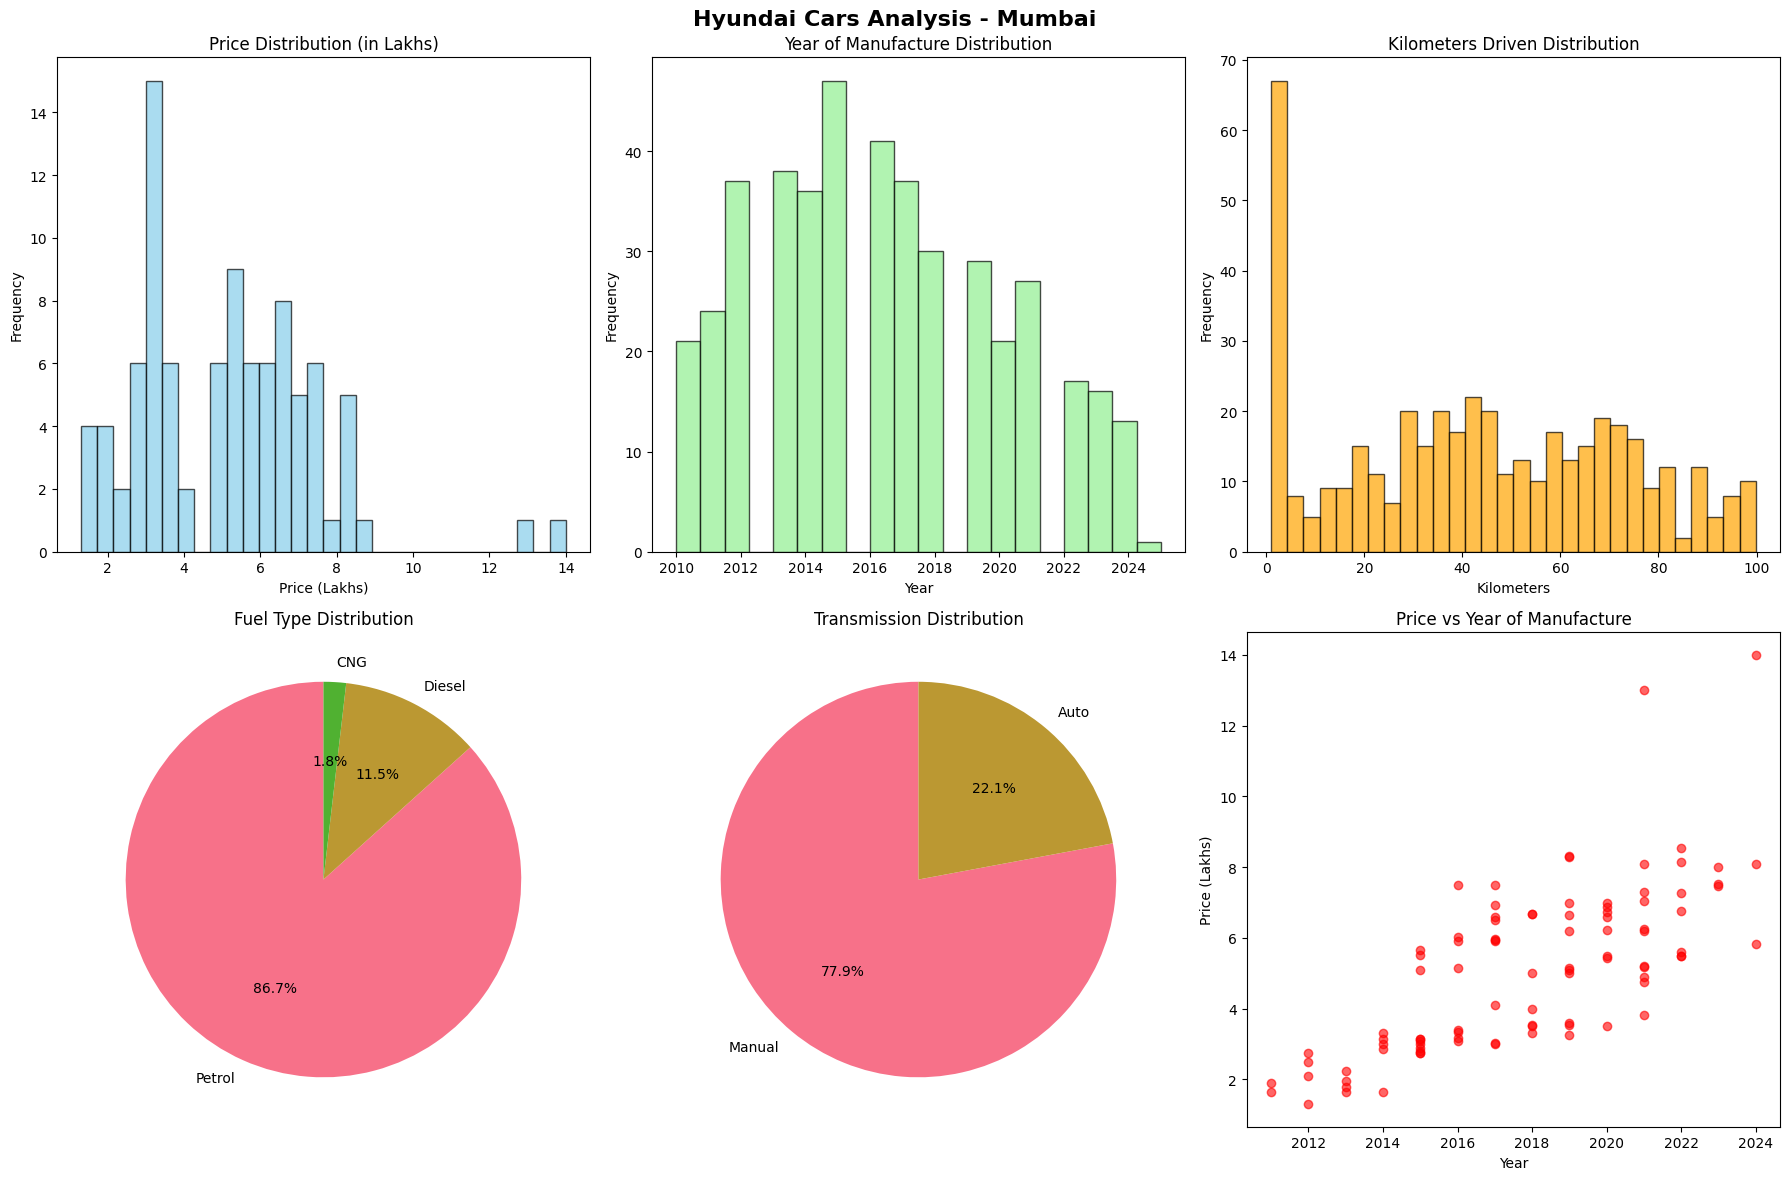


📈 Summary Statistics:
Total Cars Analyzed: 435
Average Price: ₹5.10 lakhs
Average Year: 2016
Average Kilometers: 43 km

🏆 Most Popular:
Fuel Type: Petrol (377 cars)
Transmission: Manual (339 cars)

📊 Data Quality:
Complete records: 94 out of 435
Data completeness: 21.6%

✅ Analysis complete! Charts saved as 'hyundai_cars_analysis.png'


In [14]:
# Step 12: Data Visualization and Summary

import matplotlib.pyplot as plt
import seaborn as sns

print("=== Data Visualization and Summary ===")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyundai Cars Analysis - Mumbai', fontsize=16, fontweight='bold')

# 1. Price Distribution
axes[0, 0].hist(df_clean['Price_Numeric'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price Distribution (in Lakhs)')
axes[0, 0].set_xlabel('Price (Lakhs)')
axes[0, 0].set_ylabel('Frequency')

# 2. Year Distribution
axes[0, 1].hist(df_clean['Year'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Year of Manufacture Distribution')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Frequency')

# 3. Kilometers Distribution
axes[0, 2].hist(df_clean['Kilometers_Numeric'].dropna(), bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].set_title('Kilometers Driven Distribution')
axes[0, 2].set_xlabel('Kilometers')
axes[0, 2].set_ylabel('Frequency')

# 4. Fuel Type Distribution
fuel_counts = df_clean['Fuel_Type'].value_counts()
axes[1, 0].pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Fuel Type Distribution')

# 5. Transmission Distribution
transmission_counts = df_clean['Transmission'].value_counts()
axes[1, 1].pie(transmission_counts.values, labels=transmission_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Transmission Distribution')

# 6. Price vs Year Scatter Plot
axes[1, 2].scatter(df_clean['Year'], df_clean['Price_Numeric'], alpha=0.6, color='red')
axes[1, 2].set_title('Price vs Year of Manufacture')
axes[1, 2].set_xlabel('Year')
axes[1, 2].set_ylabel('Price (Lakhs)')

# Adjust layout
plt.tight_layout()
plt.savefig('cars24_hyundai_mumbai/hyundai_cars_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary Statistics
print("\n📈 Summary Statistics:")
print(f"Total Cars Analyzed: {len(df_clean)}")
print(f"Average Price: ₹{df_clean['Price_Numeric'].mean():.2f} lakhs")
print(f"Average Year: {df_clean['Year'].mean():.0f}")
print(f"Average Kilometers: {df_clean['Kilometers_Numeric'].mean():.0f} km")

print(f"\n🏆 Most Popular:")
print(f"Fuel Type: {fuel_counts.index[0]} ({fuel_counts.iloc[0]} cars)")
print(f"Transmission: {transmission_counts.index[0]} ({transmission_counts.iloc[0]} cars)")

print(f"\n📊 Data Quality:")
print(f"Complete records: {df_final.shape[0]} out of {len(df_clean)}")
print(f"Data completeness: {(df_final.shape[0]/len(df_clean)*100):.1f}%")

print("\n✅ Analysis complete! Charts saved as 'hyundai_cars_analysis.png'")